In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import math

In [13]:
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'pyLDAvis.gensim'

In [14]:
df = pd.read_csv('/Users/joaquingomez/Downloads/dataset/full_dataset.csv')

In [8]:
df.head()

Unnamed: 0                  title  \
0           0    No-Bake Nut Cookies   
1           1  Jewell Ball'S Chicken   
2           2            Creamy Corn   
3           3          Chicken Funny   
4           4   Reeses Cups(Candy)     

                                         ingredients  \
0  ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1  ["1 small jar chipped beef, cut up", "4 boned ...   
2  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
3  ["1 large whole chicken", "2 (10 1/2 oz.) cans...   
4  ["1 c. peanut butter", "3/4 c. graham cracker ...   

                                          directions  \
0  ["In a heavy 2-quart saucepan, mix brown sugar...   
1  ["Place chipped beef on bottom of baking dish....   
2  ["In a slow cooker, combine all ingredients. C...   
3  ["Boil and debone chicken.", "Put bite size pi...   
4  ["Combine first four ingredients and press in ...   

                                              link    source  \
0   www.cookbooks.com/Recipe-Details.aspx?id=44874  Gathered   
1  www.cookbooks.com/Recipe-Details.aspx?id=699419  Gathered   
2   www.cookbooks.com/Recipe-Details.aspx?id=10570  Gathered   
3  www.cookbooks.com/Recipe-Details.aspx?id=897570  Gathered   
4  www.cookbooks.com/Recipe-Details.aspx?id=659239  Gathered   

                                                 NER  
0  ["brown sugar", "milk", "vanilla", "nuts", "bu...  
1  ["beef", "chicken breasts", "cream of mushroom...  
2  ["frozen corn", "cream cheese", "butter", "gar...  
3  ["chicken", "chicken gravy", "cream of mushroo...  
4  ["peanut butter", "graham cracker crumbs", "bu...

In [15]:
NER_list = df['NER'].to_list()

In [16]:
directions_list = df['directions'].to_list()

In [4]:
df.shape

(2231142, 7)

In [41]:
df.isnull().sum()

Unnamed: 0     0
title          0
ingredients    0
directions     0
link           0
source         0
NER            0
dtype: int64

In [9]:
df['title'].unique()

array(['No-Bake Nut Cookies', "Jewell Ball'S Chicken", 'Creamy Corn', ...,
       'Extremely Easy and Quick - Namul Daikon Salad',
       'Pan-Roasted Pork Chops With Apple Fritters',
       'Polpette in Spicy Tomato Sauce'], dtype=object)

In [253]:
df['directions'].unique()

array(['["In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine.", "Stir over medium heat until mixture bubbles all over top.", "Boil and stir 5 minutes more. Take off heat.", "Stir in vanilla and cereal; mix well.", "Using 2 teaspoons, drop and shape into 30 clusters on wax paper.", "Let stand until firm, about 30 minutes."]',
       '["Place chipped beef on bottom of baking dish.", "Place chicken on top of beef.", "Mix soup and cream together; pour over chicken. Bake, uncovered, at 275\\u00b0 for 3 hours."]',
       '["In a slow cooker, combine all ingredients. Cover and cook on low for 4 hours or until heated through and cheese is melted. Stir well before serving. Yields 6 servings."]',
       ...,
       '["Julienne the daikon and squeeze out the excess moisture.", "Combine all of the ingredients.", "Serve on a dish."]',
       '["In a large bowl, mix the apple cider with 4 cups of water, the sugar and the salt.", "Toast the bay leaves, chilies

In [17]:
# Sample the data for a quick demonstration. 
# I'd suggest using Google Colab, Databricks, Sagemaker or some other cloud sources (with free tier),
# and adjust the size of the data accordingly
n_sample = 10000
df_sample = df.sample(n=n_sample,ignore_index=True)
df_sample.head()

Unnamed: 0                        title  \
0     1420845  All-Time Favorite Guacamole   
1      106741        Garbage Bag Snack Mix   
2     1602483       Herby Ham Roll Canapes   
3       62003        Peanut Dip For Apples   
4     1987402          Rhubarb Coffee Cake   

                                         ingredients  \
0  ["1 ripe avocado (3/4 lb.)", "1/3 cup chopped ...   
1  ["14 oz. Rice Chex", "1 lb. raisins", "8 oz. u...   
2  ["4 slices white bread", "2 tablespoons butter...   
3  ["1 (8 oz.) softened cream cheese", "3/4 c. br...   
4  ["1/2 cup butter", "1-1/2 cup sugar", "2 eggs"...   

                                          directions  \
0  ["Pit and peel avocado. Place in a bowl.", "Ad...   
1  ["Melt margarine, chocolate chips and peanut b...   
2  ["Use a cookie cutter to cut heart shapes out ...   
3  ["Mix all ingredients until well blended.", "S...   
4  ["Cream butter and sugar, beat in egg and vani...   

                                                link     source  \
0  www.myrecipes.com/recipe/all-time-favorite-gua...   Gathered   
1    www.cookbooks.com/Recipe-Details.aspx?id=595270   Gathered   
2  www.yummly.com/recipe/Herby-Ham-Roll-Canapes-1...   Gathered   
3    www.cookbooks.com/Recipe-Details.aspx?id=976578   Gathered   
4                    www.foodgeeks.com/recipes/18487  Recipes1M   

                                                 NER  
0  ["avocado", "tomato", "shallots", "lime juice"...  
1  ["Rice", "raisins", "peanuts", "chocolate chip...  
2  ["white bread", "butter", "herbs", "parsley", ...  
3  ["cream cheese", "brown sugar", "granulated su...  
4  ["butter", "sugar", "eggs", "vanilla", "flour"...

In [12]:
df_sample

Unnamed: 0                                   title  \
0         756104                       Chicken Casserole   
1        1144182                             Root Mousse   
2         967562       Thai Vegetable Noodle Soup My Way   
3         675217  Uncle Henry'S Cooked Custard Ice Cream   
4         925859          Field Roast®, Onions, And Kale   
...          ...                                     ...   
9995     2027001                 STOVE TOP Broccoli Bake   
9996      197032                     Marinated Asparagus   
9997     1586082                           Cherimoya Pie   
9998      510625                      Lemon Meringue Pie   
9999      287722                             Lemon Jello   

                                            ingredients  \
0     ["1 boned chicken, 6 skinless chicken breasts ...   
1     ["2 small rutabagas (young and tender, not hug...   
2     ["2 tablespoons oil, peanut", "1 onion, sweet,...   
3     ["6 eggs", "2 c sugar", "2 qt. milk", "4 t van...   
4     ["4 Italian-flavored vegetarian sausage links ...   
...                                                 ...   
9995  ["2 eggs", "1 can (10 oz./284 mL) condensed cr...   
9996  ["2 lb. asparagus (can substitute broccoli, st...   
9997  ["2 cups Cherimoya, Seeded And Pureed*", "14-1...   
9998  ["1 c. sugar", "1/4 tsp. salt", "2 eggs, separ...   
9999  ["1 box lemon jello", "1 c. hot water", "1 c. ...   

                                             directions  \
0     ["Mix the first 4 ingredients in large cassero...   
1     ["Peel and rinse all the root veggies.", "They...   
2     ["Heat the oil in a work and stir fry the onio...   
3     ["Beat eggs and sugar in mixing bowl.", "Add a...   
4     ["Slice sausage into thick chunks.", "Coat the...   
...                                                 ...   
9995  ["Preheat oven to 350F.", "Beat eggs, soup and...   
9996  ["Pour mixture over asparagus and marinate in ...   
9997  ["Pre-bake pie shell: Poke holes in the crust,...   
9998  ["Combine sugar, cornstarch and salt in a doub...   
9999  ["Top with Cool Whip before serving.", "Can ch...   

                                                   link     source  \
0       www.cookbooks.com/Recipe-Details.aspx?id=706889   Gathered   
1                www.food.com/recipe/root-mousse-167603   Gathered   
2     www.food.com/recipe/thai-vegetable-noodle-soup...   Gathered   
3        www.cookbooks.com/Recipe-Details.aspx?id=17354   Gathered   
4     www.allrecipes.com/recipe/261322/field-roast-o...   Gathered   
...                                                 ...        ...   
9995  www.kraftrecipes.com/recipes/stove-top-broccol...  Recipes1M   
9996    www.cookbooks.com/Recipe-Details.aspx?id=620383   Gathered   
9997   tastykitchen.com/recipes/desserts/cherimoya-pie/   Gathered   
9998     www.cookbooks.com/Recipe-Details.aspx?id=28147   Gathered   
9999    www.cookbooks.com/Recipe-Details.aspx?id=930593   Gathered   

                                                    NER  
0     ["chicken", "chicken broth", "cream of chicken...  
1     ["rutabagas", "carrot", "potatoes", "vegetaria...  
2     ["oil", "onion", "garlic", "carrot", "zucchini...  
3                  ["eggs", "sugar", "milk", "vanilla"]  
4     ["Italian-flavored vegetarian sausage links", ...  
...                                                 ...  
9995  ["eggs", "condensed cream", "Mayonnaise", "bro...  
9996  ["substitute broccoli", "vinegar", "sugar", "d...  
9997  ["Milk", "Sugar", "\u00bc", "Vanilla", "Salt",...  
9998  ["sugar", "salt", "eggs", "lemon rind", "confe...  
9999  ["lemon jello", "water", "marshmallows", "pine...  

[10000 rows x 7 columns]

In [264]:
df['directions'][1].split()

['["Place',
 'chipped',
 'beef',
 'on',
 'bottom',
 'of',
 'baking',
 'dish.",',
 '"Place',
 'chicken',
 'on',
 'top',
 'of',
 'beef.",',
 '"Mix',
 'soup',
 'and',
 'cream',
 'together;',
 'pour',
 'over',
 'chicken.',
 'Bake,',
 'uncovered,',
 'at',
 '275\\u00b0',
 'for',
 '3',
 'hours."]']

In [257]:
df['directions'] = df['directions'].replace(['\\u00b0'], '')

In [250]:
df['directions'][2231141]

'["Preheat the oven to 350.", "In a bowl, mix the veal with the sausage meat, bread crumbs, milk, garlic, chopped parsley, egg whites, tomato paste and 1/2 cup of pecorino; season with salt and pepper.", "Roll into 1 1/2-inch meatballs.", "Bake the meatballs on a lightly oiled baking sheet for about 30 minutes, until browned and cooked through.", "In a large saucepan, season the tomato sauce with the crushed red pepper.", "Add the meatballs and simmer until the sauce is slightly thickened, about 8 minutes.", "Sprinkle with pecorino cheese and serve."]'

In [13]:
df['directions'][0].replace('"','').replace('[','').replace(']','').replace(',','')

'In a heavy 2-quart saucepan mix brown sugar nuts evaporated milk and butter or margarine. Stir over medium heat until mixture bubbles all over top. Boil and stir 5 minutes more. Take off heat. Stir in vanilla and cereal; mix well. Using 2 teaspoons drop and shape into 30 clusters on wax paper. Let stand until firm about 30 minutes.'

In [16]:
# Apply the cleaning 
df['clean_text'] = [i.replace('"','').replace('[','').replace(']','').replace(',','') for i in df['directions']]
df_sample['clean_text'] = [i.replace('"','').replace('[','').replace(']','').replace(',','') for i in df_sample['directions']]
df_sample = df_sample.drop(columns='Unnamed: 0')
df_sample.head()

title  \
0                       Chicken Casserole   
1                             Root Mousse   
2       Thai Vegetable Noodle Soup My Way   
3  Uncle Henry'S Cooked Custard Ice Cream   
4          Field Roast®, Onions, And Kale   

                                         ingredients  \
0  ["1 boned chicken, 6 skinless chicken breasts ...   
1  ["2 small rutabagas (young and tender, not hug...   
2  ["2 tablespoons oil, peanut", "1 onion, sweet,...   
3  ["6 eggs", "2 c sugar", "2 qt. milk", "4 t van...   
4  ["4 Italian-flavored vegetarian sausage links ...   

                                          directions  \
0  ["Mix the first 4 ingredients in large cassero...   
1  ["Peel and rinse all the root veggies.", "They...   
2  ["Heat the oil in a work and stir fry the onio...   
3  ["Beat eggs and sugar in mixing bowl.", "Add a...   
4  ["Slice sausage into thick chunks.", "Coat the...   

                                                link    source  \
0    www.cookbooks.com/Recipe-Details.aspx?id=706889  Gathered   
1             www.food.com/recipe/root-mousse-167603  Gathered   
2  www.food.com/recipe/thai-vegetable-noodle-soup...  Gathered   
3     www.cookbooks.com/Recipe-Details.aspx?id=17354  Gathered   
4  www.allrecipes.com/recipe/261322/field-roast-o...  Gathered   

                                                 NER  \
0  ["chicken", "chicken broth", "cream of chicken...   
1  ["rutabagas", "carrot", "potatoes", "vegetaria...   
2  ["oil", "onion", "garlic", "carrot", "zucchini...   
3               ["eggs", "sugar", "milk", "vanilla"]   
4  ["Italian-flavored vegetarian sausage links", ...   

                                          clean_text  
0  Mix the first 4 ingredients in large casserole...  
1  Peel and rinse all the root veggies. They need...  
2  Heat the oil in a work and stir fry the onion ...  
3  Beat eggs and sugar in mixing bowl. Add a litt...  
4  Slice sausage into thick chunks. Coat the bott...

In [17]:
df_sample.shape

(10000, 7)

In [20]:
len(NER_list)

2231142

In [21]:
NER_sample = NER_list.sample(n=n_sample,ignore_index=True)

AttributeError: 'list' object has no attribute 'sample'

In [23]:
from random import sample

In [251]:
directions_list

['["In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine.", "Stir over medium heat until mixture bubbles all over top.", "Boil and stir 5 minutes more. Take off heat.", "Stir in vanilla and cereal; mix well.", "Using 2 teaspoons, drop and shape into 30 clusters on wax paper.", "Let stand until firm, about 30 minutes."]',
 '["Place chipped beef on bottom of baking dish.", "Place chicken on top of beef.", "Mix soup and cream together; pour over chicken. Bake, uncovered, at 275\\u00b0 for 3 hours."]',
 '["In a slow cooker, combine all ingredients. Cover and cook on low for 4 hours or until heated through and cheese is melted. Stir well before serving. Yields 6 servings."]',
 '["Boil and debone chicken.", "Put bite size pieces in average size square casserole dish.", "Pour gravy and cream of mushroom soup over chicken; level.", "Make stuffing according to instructions on box (do not make too moist).", "Put stuffing on top of chicken and gravy; level."

In [55]:
directions_sample = sample(directions_list,10000)

In [26]:
NER_sample = sample(NER_list,10000)

In [27]:
NER_sample

['["butterscotch morsels", "noodles", "nuts"]',
 '["butter", "croutons", "cheddar cheese", "milk", "eggs", "mustard", "bacon"]',
 '["chicken", "water", "salt", "celery", "parsley", "onion", "bay leaf", "potatoes", "corn", "eggs", "parsley", "heavy cream"]',
 '["marshmallows", "lemon juice", "almond extract", "maraschino cherries", "whipping cream", "pistachios"]',
 '["oysters", "oyster stew", "onion", "herb stuffing mix", "celery", "eggs", "crackers", "chicken broth", "salt"]',
 '["yellow mustard", "cider vinegar", "lemon juice", "brown sugar"]',
 '["hearts", "tomato", "freshly grated parmesan cheese", "fresh basil", "extra virgin olive oil", "Italian rolls", "provolone cheese", "salami"]',
 '["steamed Japanese", "sesame seeds", "nori", "salmon", "salt"]',
 '["eggs", "milk", "butter", "flour", "salt"]',
 '["shell", "flour", "sugar", "baking powder", "salt", "unsalted butter", "eggs", "vanilla pastry cream", "milk", "cornstarch", "sugar", "egg +", "butter", "vanilla bean", "blueberries"

In [53]:
df['directions'].str.len()

0           357
1           175
2           171
3           394
4           229
           ... 
2231137     880
2231138     423
2231139     115
2231140    2315
2231141     556
Name: directions, Length: 2231142, dtype: int64

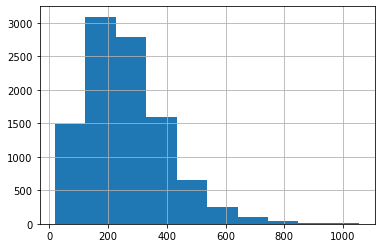

In [64]:
directions_sample2.str.len().hist()

In [62]:
directions_sample2 = df['directions'][0:10000]

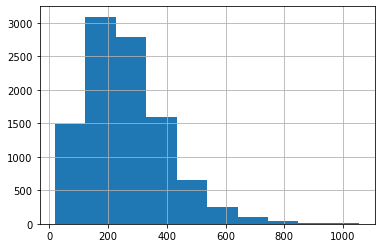

In [63]:
directions_sample2.str.len().hist()

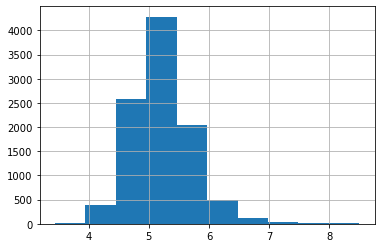

In [65]:
directions_sample2.str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

In [179]:
# NLTK Stop words
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [370]:
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joaquingomez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [374]:
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

In [367]:
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords

def plot_top_stopwords_barchart(text):
    stop=stopwords
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

In [176]:
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 'ours',
 '

In [173]:
stopwords.words('english')

AttributeError: 'set' object has no attribute 'words'

In [172]:
set(stopwords.words('english'))

AttributeError: 'set' object has no attribute 'words'

In [ ]:
direc

In [241]:
directions_sample3 = sample(directions_list,100000)

In [242]:
type(directions_sample3)

list

In [243]:
directions_sample3 = df['directions'][0:100000]

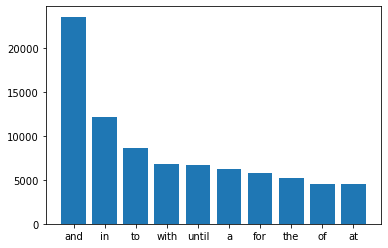

In [244]:
plot_top_stopwords_barchart(directions_sample3)

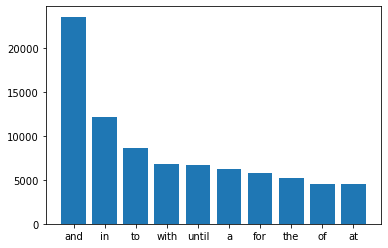

In [72]:
plot_top_stopwords_barchart(directions_sample2)

In [ ]:
directions_sample3.

In [211]:
type(directions_sample2)

pandas.core.series.Series

In [212]:
type(directions_sample3)

list

In [229]:
directions_sample3.str.split()

0        [["In, a, heavy, 2-quart, saucepan,, mix, brow...
1        [["Place, chipped, beef, on, bottom, of, bakin...
2        [["In, a, slow, cooker,, combine, all, ingredi...
3        [["Boil, and, debone, chicken.",, "Put, bite, ...
4        [["Combine, first, four, ingredients, and, pre...
                               ...                        
99995    [["Whisk, the, first, 5, ingredients, together...
99996    [["Beat, shortening,, sugar,, pumpkin, and, eg...
99997            [["Stir, all, ingredients, and, chill."]]
99998    [["Wash, and, rinse, beans, carefully,, select...
99999    [["Preheat, oven, to, 250\u00b0.",, "Melt, mar...
Name: directions, Length: 100000, dtype: object

In [227]:
directions_sample3.replace('250\u00b0','')

0        ["In a heavy 2-quart saucepan, mix brown sugar...
1        ["Place chipped beef on bottom of baking dish....
2        ["In a slow cooker, combine all ingredients. C...
3        ["Boil and debone chicken.", "Put bite size pi...
4        ["Combine first four ingredients and press in ...
                               ...                        
99995    ["Whisk the first 5 ingredients together in bo...
99996    ["Beat shortening, sugar, pumpkin and egg in m...
99997                  ["Stir all ingredients and chill."]
99998    ["Wash and rinse beans carefully, selecting ou...
99999    ["Preheat oven to 250\u00b0.", "Melt margarine...
Name: directions, Length: 100000, dtype: object

In [223]:
directions_sample3 = directions_sample3.str.replace('\u00b0.','')

In [224]:
directions_sample3

0        ["In a heavy 2-quart saucepan, mix brown sugar...
1        ["Place chipped beef on bottom of baking dish....
2        ["In a slow cooker, combine all ingredients. C...
3        ["Boil and debone chicken.", "Put bite size pi...
4        ["Combine first four ingredients and press in ...
                               ...                        
99995    ["Whisk the first 5 ingredients together in bo...
99996    ["Beat shortening, sugar, pumpkin and egg in m...
99997                  ["Stir all ingredients and chill."]
99998    ["Wash and rinse beans carefully, selecting ou...
99999    ["Preheat oven to 250\u00b0.", "Melt margarine...
Name: directions, Length: 100000, dtype: object

In [232]:
type(new)

list

In [357]:
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

In [362]:
df['clean_text'] = [i.replace('"','').replace('[','').replace(']','').replace(',','') for i in df['directions']]

In [376]:
df['clean_text'] = [i.replace('.','') for i in df['clean_text']]

In [364]:
df['clean_text']

0          In a heavy 2-quart saucepan mix brown sugar nu...
1          Place chipped beef on bottom of baking dish. P...
2          In a slow cooker combine all ingredients. Cove...
3          Boil and debone chicken. Put bite size pieces ...
4          Combine first four ingredients and press in 13...
                                 ...                        
2231137    Spread hazelnut spread on 1 side of each torti...
2231138    Boil eggs on medium for 30mins. Then cool eggs...
2231139    Julienne the daikon and squeeze out the excess...
2231140    In a large bowl mix the apple cider with 4 cup...
2231141    Preheat the oven to 350. In a bowl mix the vea...
Name: clean_text, Length: 2231142, dtype: object

In [369]:
df['clean_text'] = df['clean_text'].str.lower()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/utils.py:551: DeprecationWarning:

`np.float` is a depr

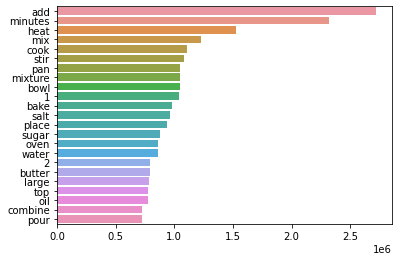

In [377]:
plot_top_non_stopwords_barchart(df['clean_text'])

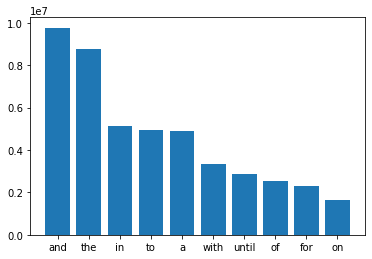

In [375]:
plot_top_stopwords_barchart(df['clean_text'])

In [360]:
df['directions'] = [word.replace('u00b0','') for word in df['directions']]

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/utils.py:551: DeprecationWarning:

`np.float` is a depr

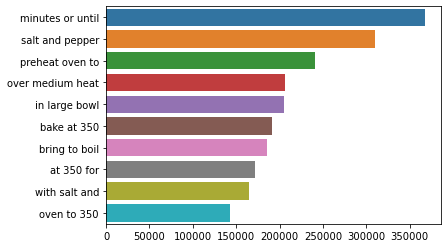

In [361]:
top_tri_grams=get_top_ngram(df['directions'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

In [234]:
directions_sample3=[word.replace('u00b0','') for word in directions_sample3]

In [235]:
directions_sample3=[word.replace('\\','') for word in directions_sample3]

In [236]:
directions_sample3

['["In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine.", "Stir over medium heat until mixture bubbles all over top.", "Boil and stir 5 minutes more. Take off heat.", "Stir in vanilla and cereal; mix well.", "Using 2 teaspoons, drop and shape into 30 clusters on wax paper.", "Let stand until firm, about 30 minutes."]',
 '["Place chipped beef on bottom of baking dish.", "Place chicken on top of beef.", "Mix soup and cream together; pour over chicken. Bake, uncovered, at 275u00b0 for 3 hours."]',
 '["In a slow cooker, combine all ingredients. Cover and cook on low for 4 hours or until heated through and cheese is melted. Stir well before serving. Yields 6 servings."]',
 '["Boil and debone chicken.", "Put bite size pieces in average size square casserole dish.", "Pour gravy and cream of mushroom soup over chicken; level.", "Make stuffing according to instructions on box (do not make too moist).", "Put stuffing on top of chicken and gravy; level.", 

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/utils.py:551: DeprecationWarning:

`np.float` is a depr

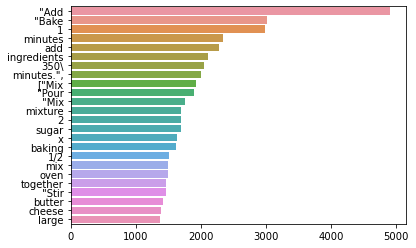

In [356]:
plot_top_non_stopwords_barchart(df['directions'])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/utils.py:551: DeprecationWarning:

`np.float` is a depr

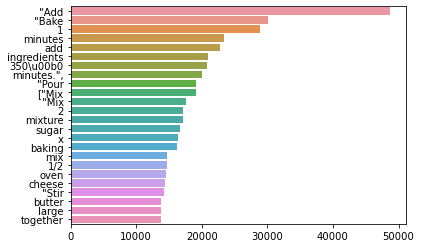

In [204]:
plot_top_non_stopwords_barchart(directions_sample3)

In [163]:
len(directions_sample2)

10000

In [213]:
len(directions_sample3)

100000

In [77]:
from nltk.util import ngrams

In [78]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

In [343]:
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    #new= directions_sample3
    new= directions4.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

In [337]:
type(directions_sample3)

pandas.core.series.Series

In [341]:
directions4 = pd.Series(directions3)

In [342]:
directions4

0       ["In a heavy 2-quart saucepan, mix brown sugar...
1       ["Place chipped beef on bottom of baking dish....
2       ["In a slow cooker, combine all ingredients. C...
3       ["Boil and debone chicken.", "Put bite size pi...
4       ["Combine first four ingredients and press in ...
                              ...                        
9995               ["Combine all ingredients and chill."]
9996    ["Cut steaks into strips; brown in cooking oil...
9997    ["Stew and bone fryer.", "Saute in small amoun...
9998    ["Mix together for 2 or 3 minutes. Put into gr...
9999    ["Layer each ingredients, prepared according t...
Length: 10000, dtype: object

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/utils.py:551: DeprecationWarning:

`np.float` is a depr

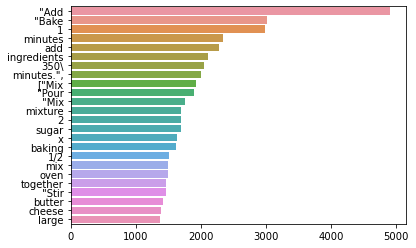

In [344]:
plot_top_non_stopwords_barchart(directions4)

In [79]:
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= directions_sample2.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/utils.py:551: DeprecationWarning:

`np.float` is a depr

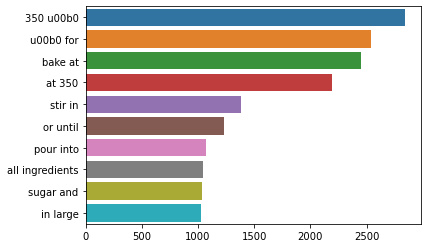

In [80]:
plot_top_ngrams_barchart(directions_sample2,2)

In [162]:
plot_top_ngrams_barchart(directions_sample2,2)

AttributeError: 'set' object has no attribute 'words'

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/utils.py:551: DeprecationWarning:

`np.float` is a depr

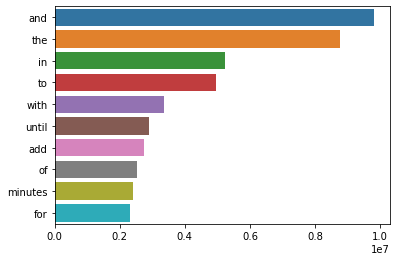

In [351]:
top_tri_grams=get_top_ngram(df['directions'],n=1)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/utils.py:551: DeprecationWarning:

`np.float` is a depr

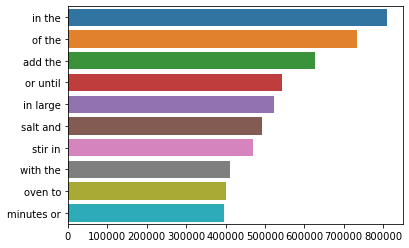

In [352]:
top_tri_grams=get_top_ngram(df['directions'],n=2)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/utils.py:551: DeprecationWarning:

`np.float` is a depr

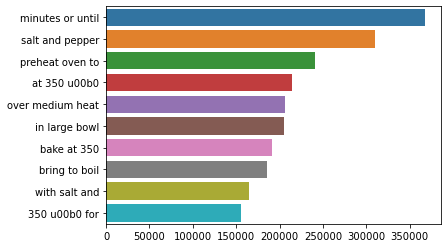

In [353]:
top_tri_grams=get_top_ngram(df['directions'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

In [350]:
df['directions']

0          ["In a heavy 2-quart saucepan, mix brown sugar...
1          ["Place chipped beef on bottom of baking dish....
2          ["In a slow cooker, combine all ingredients. C...
3          ["Boil and debone chicken.", "Put bite size pi...
4          ["Combine first four ingredients and press in ...
                                 ...                        
2231137    ["Spread hazelnut spread on 1 side of each tor...
2231138    ["Boil eggs on medium for 30mins.", "Then cool...
2231139    ["Julienne the daikon and squeeze out the exce...
2231140    ["In a large bowl, mix the apple cider with 4 ...
2231141    ["Preheat the oven to 350.", "In a bowl, mix t...
Name: directions, Length: 2231142, dtype: object

In [349]:
type(directions_sample2)

pandas.core.series.Series

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/utils.py:551: DeprecationWarning:

`np.float` is a depr

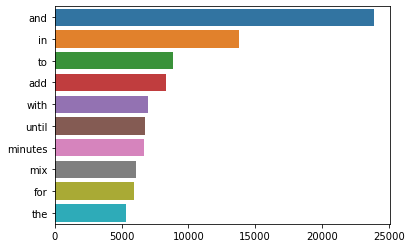

In [328]:
top_tri_grams=get_top_ngram(directions_sample2,n=1)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

In [ ]:
top_tri_grams=get_top_ngram(directions3,n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/utils.py:551: DeprecationWarning:

`np.float` is a depr

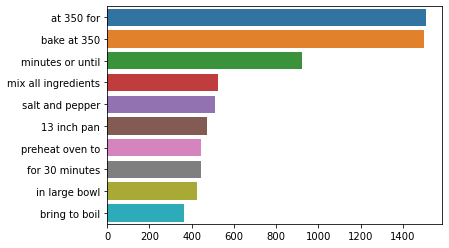

In [168]:
top_tri_grams=get_top_ngram(directions3,n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:332: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/utils.py:551: DeprecationWarning:

`np.float` is a depr

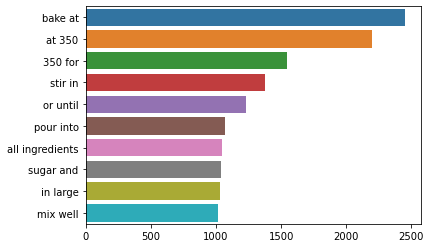

In [169]:
top_bi_grams2=get_top_ngram(directions3,n=2)
x,y=map(list,zip(*top_bi_grams2))
sns.barplot(x=y,y=x)

In [166]:
directions3=[word.replace('u00b0','') for word in directions_sample2]

In [151]:
corpus

['["In',
 'a',
 'heavy',
 '2-quart',
 'saucepan,',
 'mix',
 'brown',
 'sugar,',
 'nuts,',
 'evaporated',
 'milk',
 'and',
 'butter',
 'or',
 'margarine.",',
 '"Stir',
 'over',
 'medium',
 'heat',
 'until',
 'mixture',
 'bubbles',
 'all',
 'over',
 'top.",',
 '"Boil',
 'and',
 'stir',
 '5',
 'minutes',
 'more.',
 'Take',
 'off',
 'heat.",',
 '"Stir',
 'in',
 'vanilla',
 'and',
 'cereal;',
 'mix',
 'well.",',
 '"Using',
 '2',
 'teaspoons,',
 'drop',
 'and',
 'shape',
 'into',
 '30',
 'clusters',
 'on',
 'wax',
 'paper.",',
 '"Let',
 'stand',
 'until',
 'firm,',
 'about',
 '30',
 'minutes."]',
 '["Place',
 'chipped',
 'beef',
 'on',
 'bottom',
 'of',
 'baking',
 'dish.",',
 '"Place',
 'chicken',
 'on',
 'top',
 'of',
 'beef.",',
 '"Mix',
 'soup',
 'and',
 'cream',
 'together;',
 'pour',
 'over',
 'chicken.',
 'Bake,',
 'uncovered,',
 'at',
 '275\\u00b0',
 'for',
 '3',
 'hours."]',
 '["In',
 'a',
 'slow',
 'cooker,',
 'combine',
 'all',
 'ingredients.',
 'Cover',
 'and',
 'cook',
 'on',
 '

In [153]:
corpus=[word.replace('\\u00b0','') for word in corpus]

In [150]:
map(lambda x: str.replace(x, "u00b0", ""), corpus)

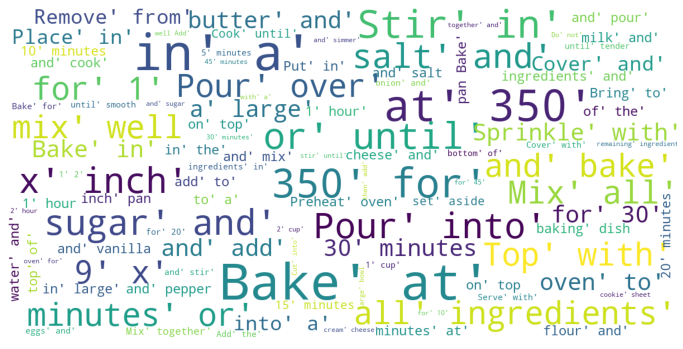

In [154]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

# BERTopic

In [18]:
from bertopic import BERTopic
# from flair.embeddings import TransformerDocumentEmbeddings

In [37]:
## Unsupervised training
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(NER_sample)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


In [38]:
# This instance show the topic IDs, counts and surfacing tokens for each topic
topic_model.get_topic_info()

Topic  Count                                       Name
0       0   5737                0_pepper_onion_garlic_sauce
1      -1   1787              -1_sugar_vanilla_baking_flour
2       1    197                   1_juice_ale_orange_vodka
3       2    151                    2_yeast_active_warm_dry
4       3    145               3_soda_chips_chocolate_brown
5       4    123      4_chips_chocolate_marshmallows_peanut
6       5    121                    5_flour_corn_milk_water
7       6    115                    6_syrup_corn_light_karo
8       7     98             7_baking_powder_cornmeal_flour
9       8     77             8_apples_cinnamon_orange_apple
10      9     58               9_cocoa_baking_u00bc_vanilla
11     10     58                 10_vanilla_yolks_egg_flour
12     11     57        11_baking_vanilla_powder_allpurpose
13     12     57       12_strawberries_banana_yogurt_frozen
14     13     55            13_soda_raisins_cinnamon_cloves
15     14     54                    14_cake_yellow_mix_eggs
16     15     51                15_yolks_vanilla_heavy_milk
17     16     50            16_cocoa_vanilla_chocolate_oleo
18     17     48                17_crust_pie_graham_cracker
19     18     48                18_pumpkin_spice_pie_nutmeg
20     19     46              19_dates_raisins_oats_candied
21     20     44         20_sweet_potatoes_mashed_margarine
22     21     43         21_jello_boiling_gelatin_pineapple
23     22     41           22_graham_cracker_crumbs_filling
24     23     40             23_cider_cloves_apple_cinnamon
25     24     39              24_cream_ice_vanilla_whipping
26     25     35          25_bananas_soda_baking_shortening
27     26     34           26_baking_buttermilk_soda_powder
28     27     34            27_love_zero_greetings_sympathy
29     28     33     28_cranberries_grapes_pineapple_orange
30     29     30           29_molasses_ginger_cloves_ground
31     30     29                30_lemon_baking_flour_juice
32     31     25               31_cocoa_peanut_oats_oatmeal
33     32     23             32_pastry_shell_sheet_hazelnut
34     33     22            33_chocolate_cake_chips_pudding
35     34     22            34_corn_kernel_creamstyle_whole
36     35     22           35_zucchini_baking_soda_cinnamon
37     36     22         36_rhubarb_flour_pineapple_peaches
38     37     21             37_graham_cracker_crumbs_chips
39     38     21             38_tea_cloves_cinnamon_instant
40     39     20            39_cherry_filling_pie_pineapple
41     40     20           40_cocoa_coffee_powdered_instant
42     41     19            41_baking_soda_pumpkin_cinnamon
43     42     19           42_pudding_powdered_instant_oleo
44     43     18           43_cookies_oreo_pudding_powdered
45     44     17          44_cottage_jello_oranges_mandarin
46     45     14  45_pistachio_pudding_marshmallows_instant
47     46     14            46_light_brown_pecans_margarine
48     47     14          47_pudding_wafers_instant_bananas
49     48     14           48_rice_raisins_golden_condensed
50     49     14          49_pudding_cake_pineapple_instant
51     50     13           50_coffee_vanilla_vodka_hienergy
52     51     12                    51_cake_lemon_mix_poppy
53     52     12          52_cinnamon_all_milliliters_honey
54     53     12        53_blueberries_baking_whites_powder
55     54     12           54_wafers_frango_candied_vanilla
56     55     11  55_mandarin_oranges_marshmallows_cocktail
57     56     11     56_cinnamon_baking_allpurpose_streusel
58     57     11              57_carrots_orange_brown_young
59     58     10          58_condensed_milk_cheerwine_liter

In [39]:
## Reduce the number of topics
n_topics = 10
new_topics, new_probs = topic_model.reduce_topics(NER_sample, topics, probs, nr_topics=n_topics)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


In [40]:
topic_model.get_topic_info()

Topic  Count                                   Name
0       0   5737             0_pepper_onion_salt_garlic
1      -1   2775          -1_sugar_vanilla_baking_flour
2       1    268         1_juice_pineapple_orange_jello
3       2    194         2_cinnamon_apples_sugar_orange
4       3    166             3_cocoa_vanilla_sugar_milk
5       4    159           4_brown_sugar_chocolate_soda
6       5    151             5_yeast_flour_water_active
7       6    145  6_chocolate_chips_marshmallows_peanut
8       7    143                 7_corn_flour_eggs_milk
9       8    132             8_baking_powder_flour_salt
10      9    130            9_graham_cracker_pie_crumbs

In [41]:
topic_model.visualize_topics()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairw

In [42]:
## Let's see if 3 topics is giving something more useful
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(NER_sample)
n_topics = 3
new_topics, new_probs = topic_model.reduce_topics(NER_sample, topics, probs, nr_topics=n_topics)
topic_model.visualize_topics()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:57: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:57: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:57: DeprecationWarning:

`n

TypeError: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.

In [43]:
topic_model.get_topic_info()

Topic  Count                            Name
0      0   5740      0_pepper_salt_onion_garlic
1     -1   3630   -1_sugar_vanilla_flour_butter
2      1    320  1_juice_pineapple_orange_water
3      2    310    2_cinnamon_sugar_baking_soda

In [44]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import SentenceTransformer, util
import torch

In [45]:
## Calculate sentence embeddings
model = SentenceTransformer('all-MiniLM-L12-v2')
corpus = NER_sample
sentence_embeddings = model.encode(corpus, convert_to_tensor=True)

In [46]:
## Recommendation
# Query sentences:
queries = ['pasta, basil, olive oil, cheese, tomato, mushroom, milk', 
           'cacao, flour, sugar, egg, baking, soda', 
           'chuck, roast, potato, mushroom, rice']
# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = min(5, len(corpus))
for query in queries:
    query_embedding = model.encode(query, convert_to_tensor=True)

    # We use cosine-similarity and torch.topk to find the highest 5 scores
    cos_scores = util.cos_sim(query_embedding, sentence_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")

    for score, idx in zip(top_results[0], top_results[1]):
        print(corpus[idx], "(Score: {:.4f})".format(score))





Query: pasta, basil, olive oil, cheese, tomato, mushroom, milk

Top 5 most similar sentences in corpus:
["basil", "nuts", "olive oil", "tomatoes", "olive oil", "garlic", "mushrooms", "salt", "cayenne pepper", "pasta"] (Score: 0.8474)
["onion", "olive oil", "garlic", "tomato sauce", "tomatoes", "basil", "pepper", "milk", "all-purpose", "egg", "bread crumbs", "Parmesan cheese", "salt", "chicken", "butter", "mozzarella cheese"] (Score: 0.8392)
["eggplant", "tomato", "basil", "thin slices Mozzarella cheese", "olive oil", "fresh ground pepper"] (Score: 0.8363)
["pasta noodles", "garlic", "olive oil", "onion", "fresh basil", "parmesan cheese"] (Score: 0.8339)
["beef", "onion", "zucchini", "basil", "garlic", "celery salt", "Pepper", "tomato soup", "cottage cheese", "Parmesan cheese", "Mozzarella cheese"] (Score: 0.8283)




Query: cacao, flour, sugar, egg, baking, soda

Top 5 most similar sentences in corpus:
["flour", "sugar", "baking soda", "cocoa", "baking powder", "salt", "shortening"

# Top2Vec

In [322]:
directions_sample100k = sample(directions_list,100000)

In [323]:
directions_sample100k

['["Mix well and in 1 qt of boiling water add in balls the size of baseballs and simmer 10 to 12 min."]',
 '["Slice squash, boil until soft", "With a potato masher, mash hot squash with butter.", "Add onions, cheeses, sour cream and mix well.", "Melt remaining 2 T butter and mix with bread crumbs.", "Put squash mixture into buttered baking dish. Top with crumbs."]',
 '["Melt the butter.", "Add the brown sugar.", "Boil and stir on low heat about 1 minute.", "Add the hot milk; stir constantly until it thickens somewhat.", "Remove from heat; cool a few minutes.", "While still warm, add about 1/4 cup or more confectioners sugar, depending on how thick you like your frosting to be."]',
 '["In a large saucepan, bring broth to a boil. Stir in orzo; return to a boil. Reduce heat; simmer, covered, until al dente, 8-10 minutes.", "In a large bowl, toss spinach and warm orzo, allowing spinach to wilt slightly. Add tomatoes, chickpeas, parsley and green onions.", "Whisk together dressing ingredien

In [324]:
top2vecmodel100k = Top2Vec(documents=directions_sample100k, speed="learn", workers=8)

2022-06-21 11:02:53,149 - top2vec - INFO - Pre-processing documents for training
2022-06-21 11:03:14,506 - top2vec - INFO - Creating joint document/word embedding
2022-06-21 11:12:30,403 - top2vec - INFO - Creating lower dimension embedding of documents
2022-06-21 11:15:09,999 - top2vec - INFO - Finding dense areas of documents


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2022-06-21 11:15:17,158 - top2vec - INFO - Finding topics


In [325]:
top2vecmodel100k.get_num_topics()

997

In [127]:
from top2vec import Top2Vec

top2vecmodel = Top2Vec(documents=directions_sample, speed="learn", workers=8)

2022-06-17 11:04:33,090 - top2vec - INFO - Pre-processing documents for training
2022-06-17 11:04:35,066 - top2vec - INFO - Creating joint document/word embedding
2022-06-17 11:05:11,008 - top2vec - INFO - Creating lower dimension embedding of documents
2022-06-17 11:05:30,555 - top2vec - INFO - Finding dense areas of documents
2022-06-17 11:05:30,885 - top2vec - INFO - Finding topics


In [128]:
top2vecmodel.get_num_topics()

96

In [129]:
topic_sizes, topic_nums = top2vecmodel.get_topic_sizes()

In [130]:
topic_words, word_scores, topic_nums = top2vecmodel.get_topics(2)

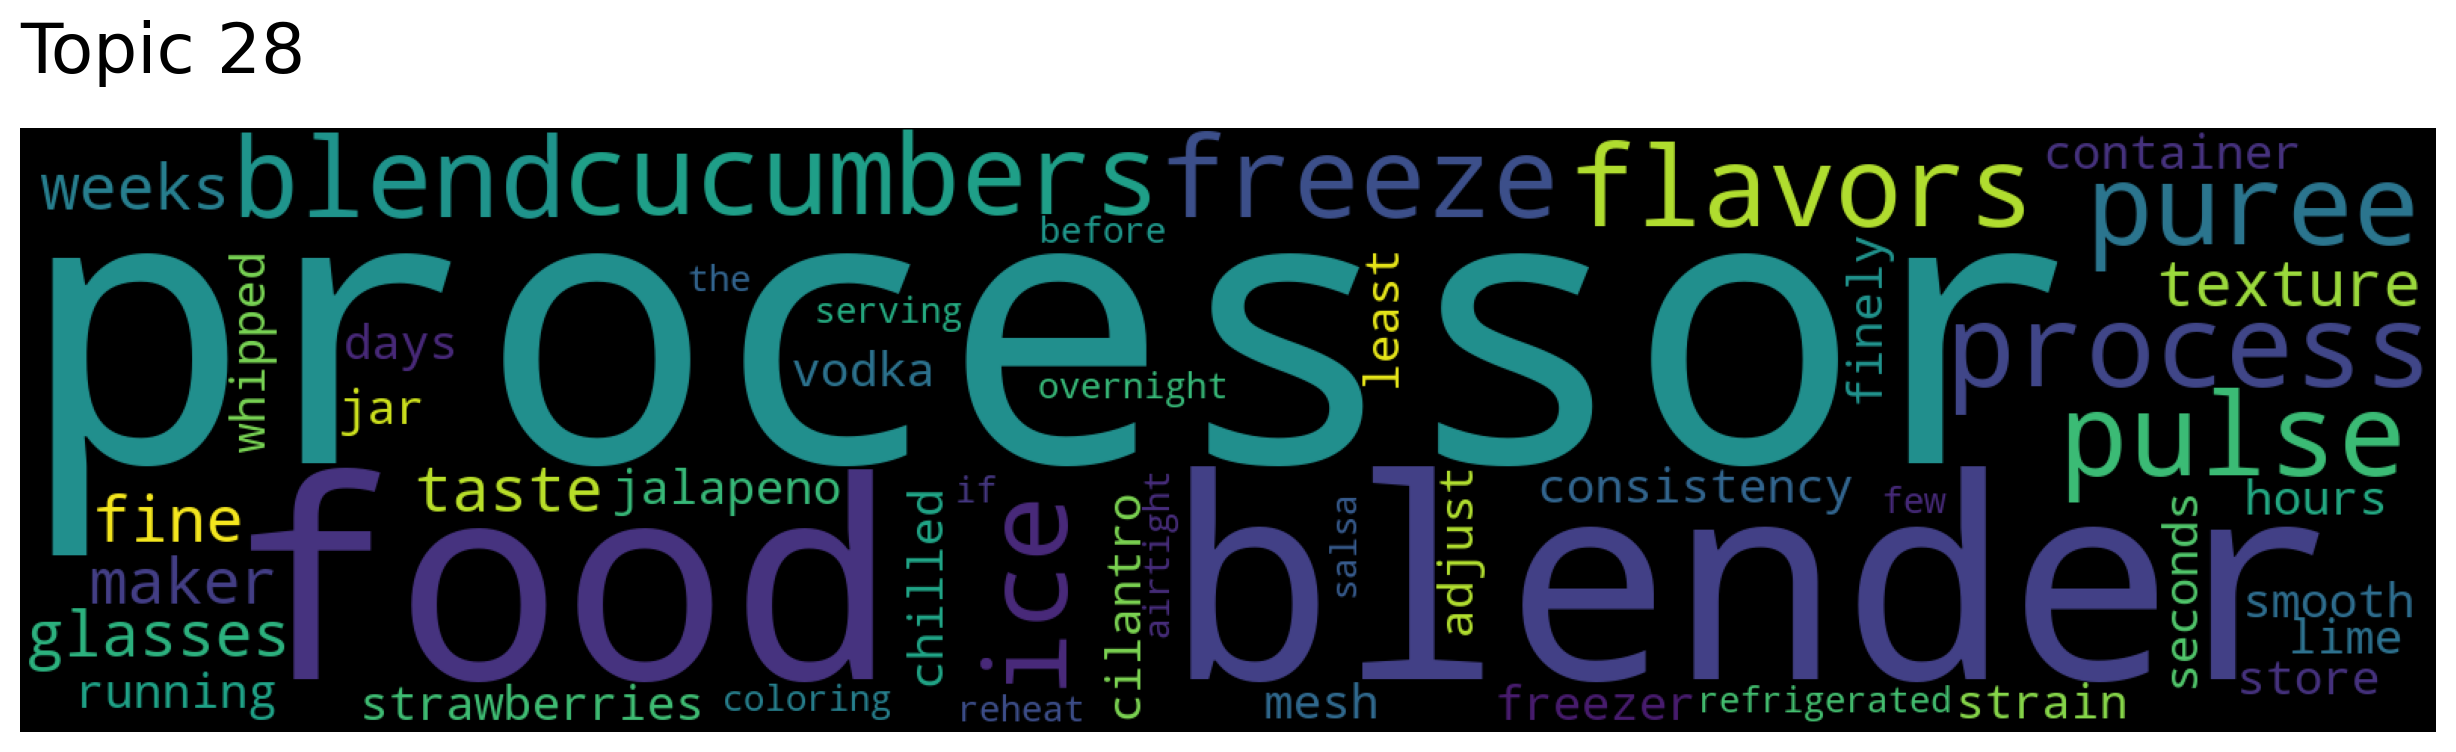

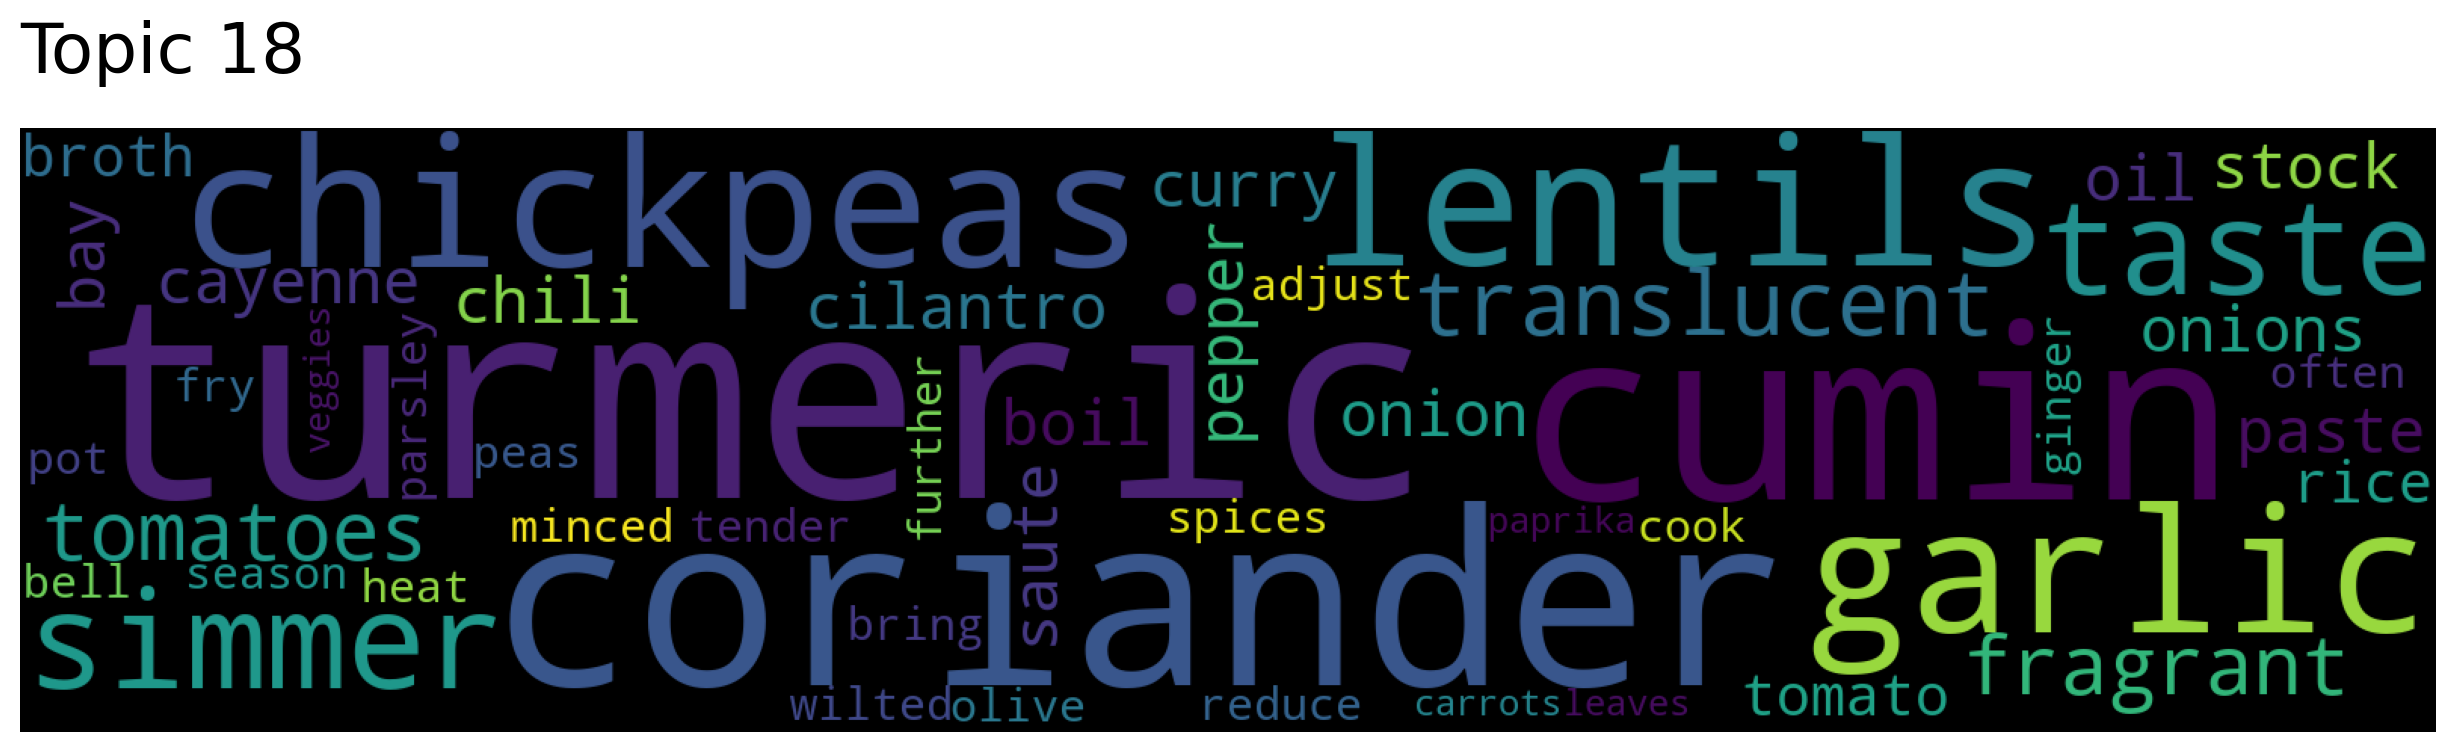

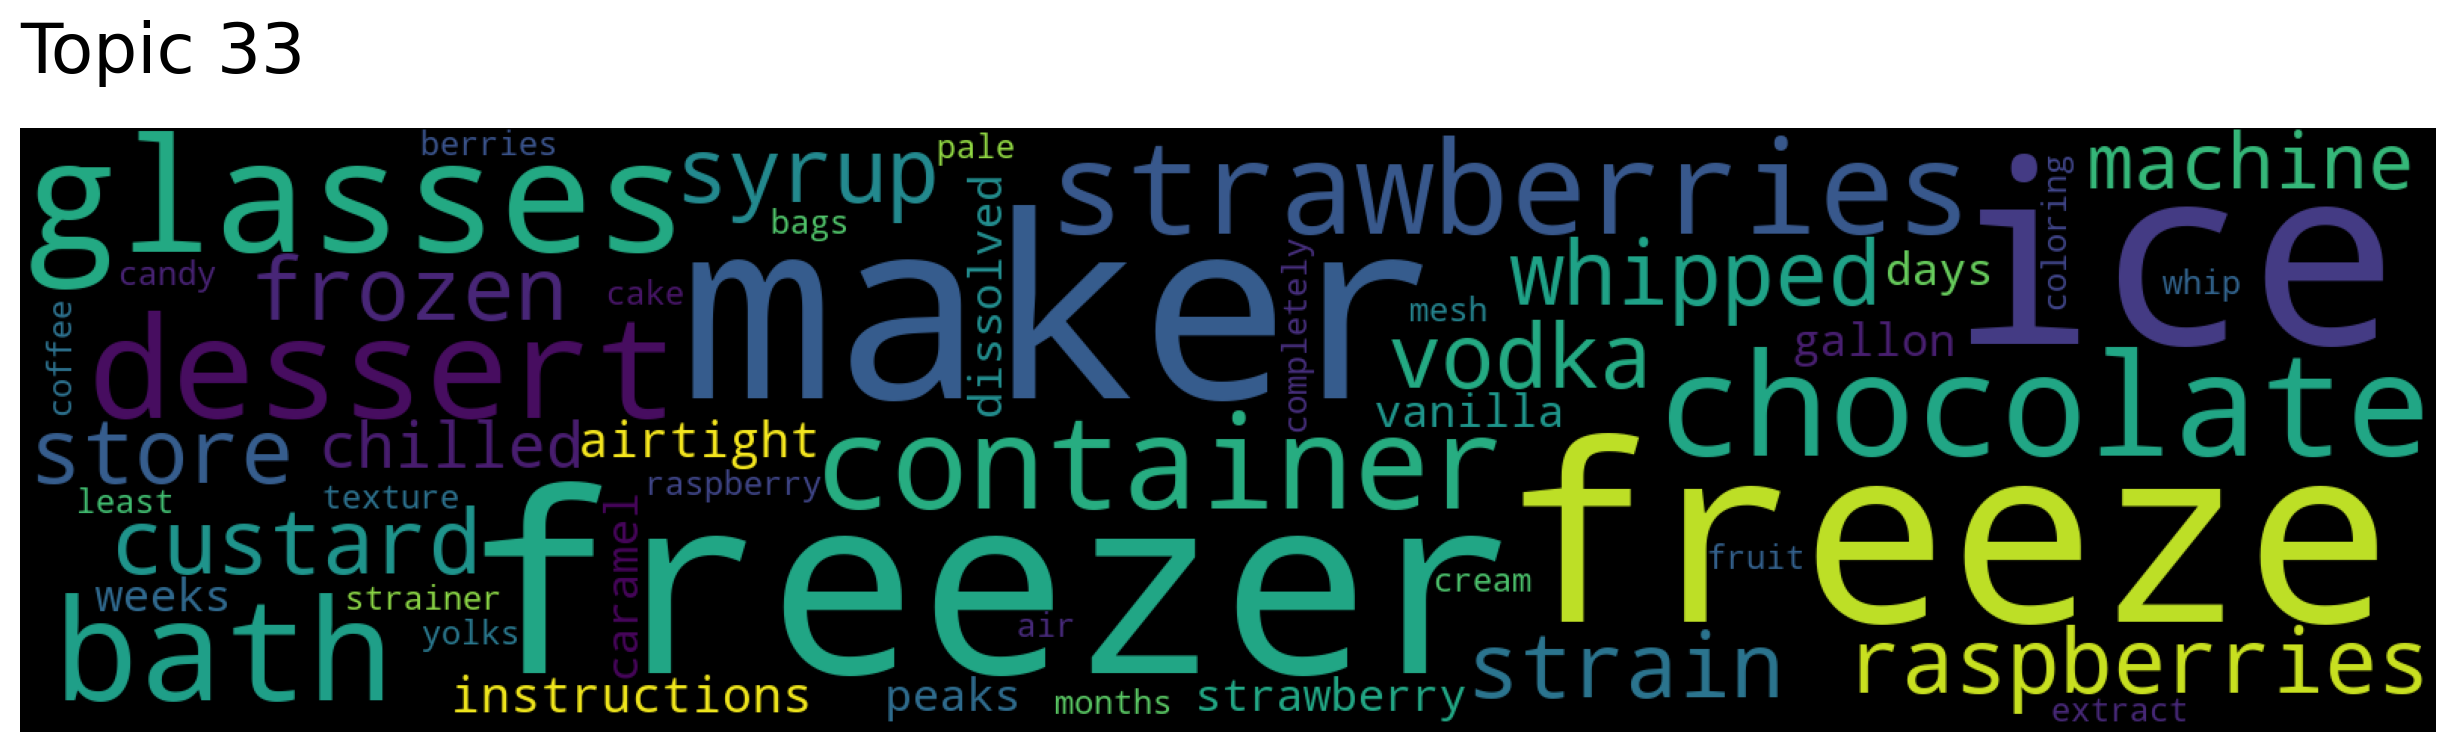

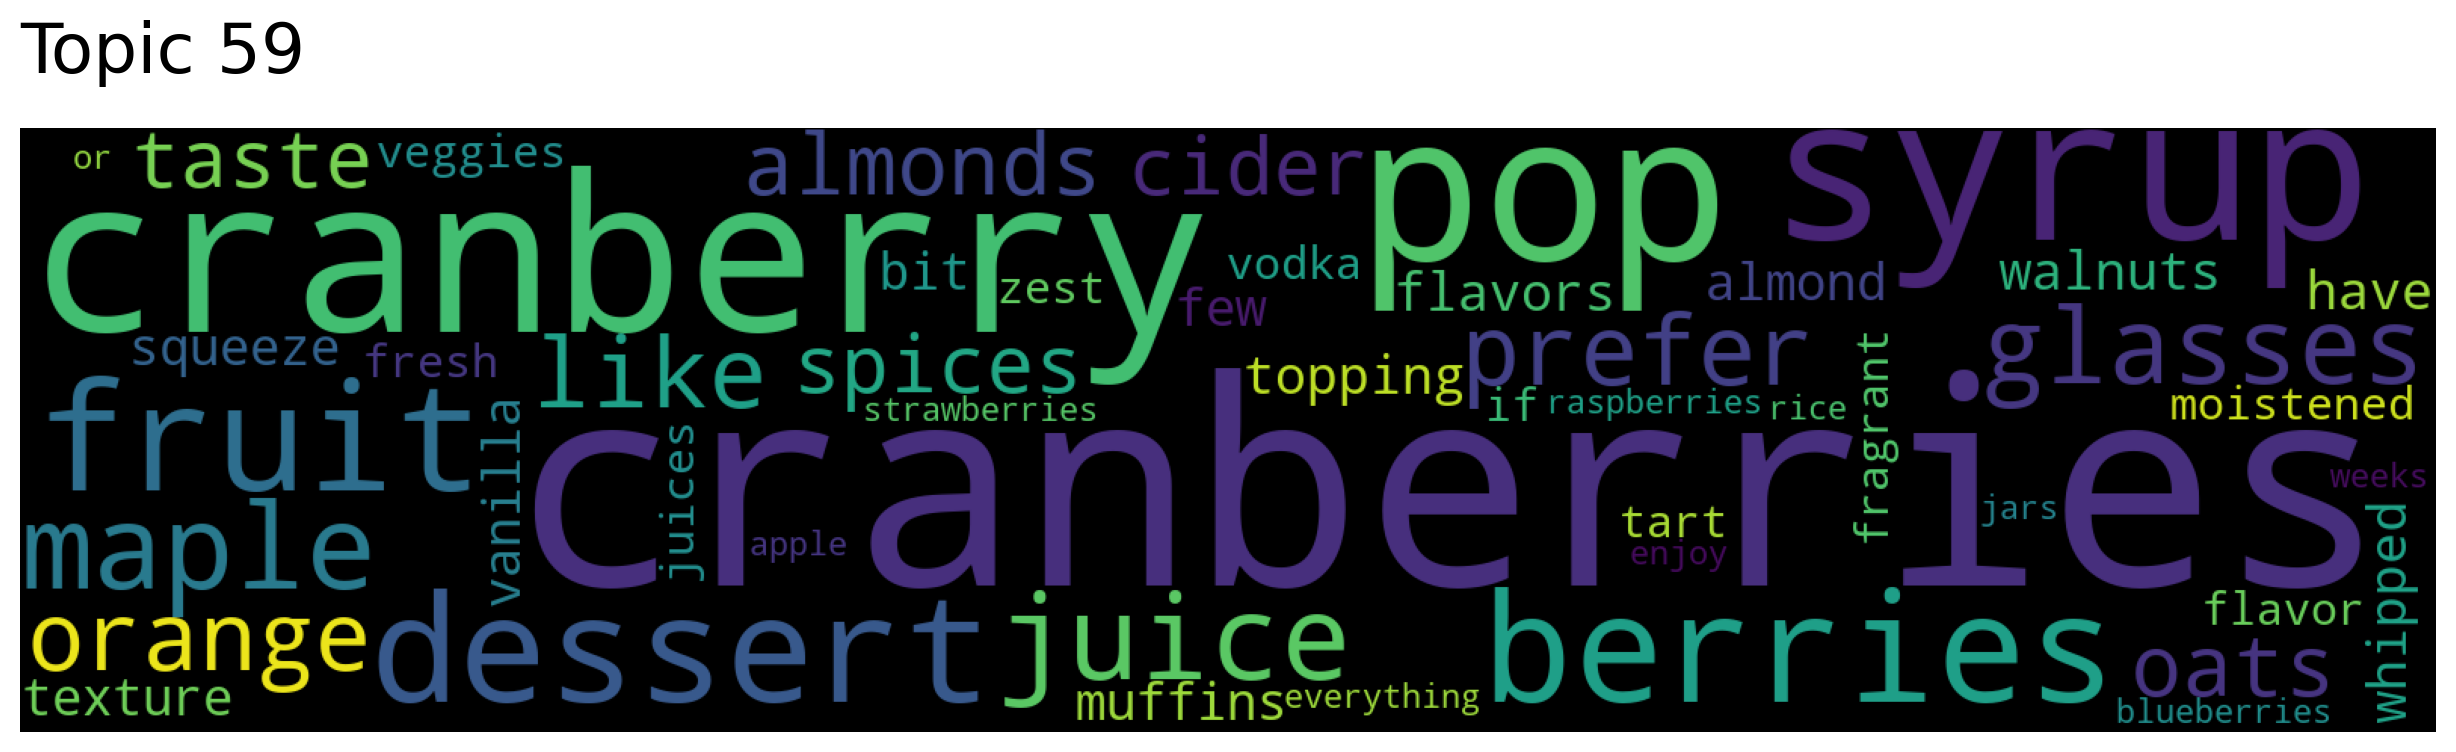

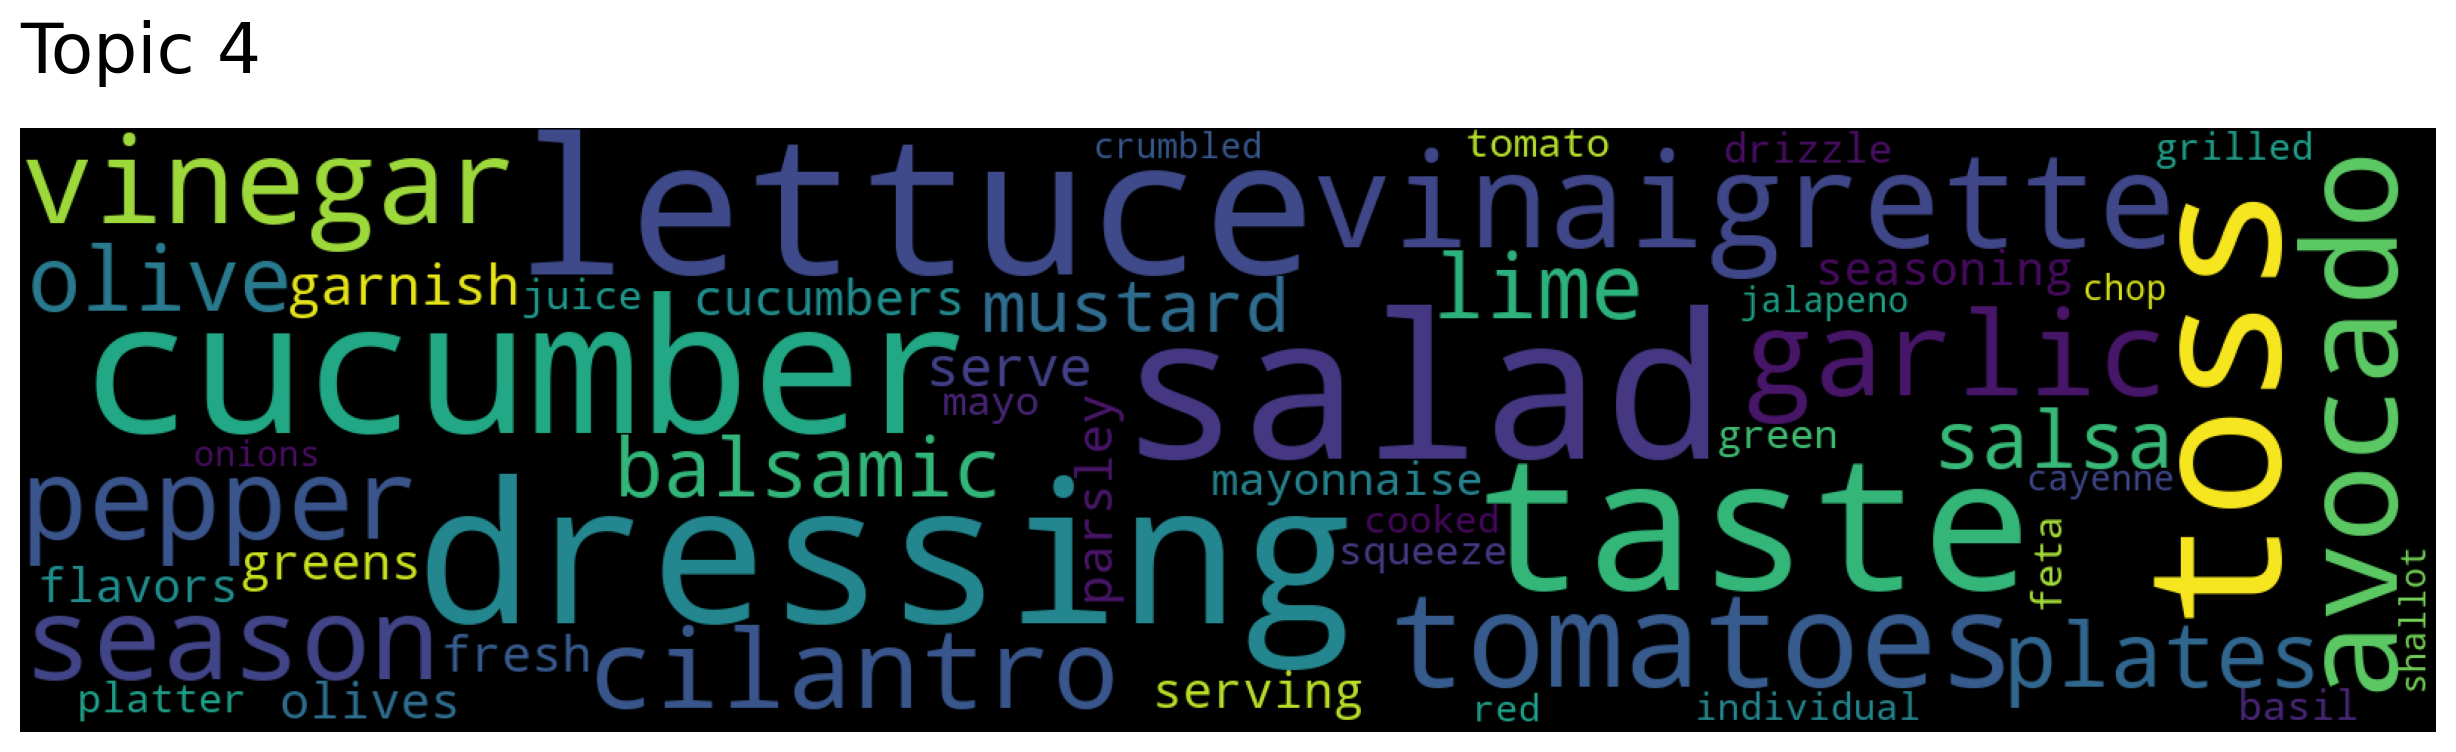

In [132]:
topic_words, word_scores, topic_scores, topic_nums = top2vecmodel.search_topics(keywords=["food"], num_topics=5)
for topic in topic_nums:
    top2vecmodel.generate_topic_wordcloud(topic)

In [133]:
documents, document_scores, document_ids = top2vecmodel.search_documents_by_topic(topic_num=4, num_docs=5)

In [144]:
df

Unnamed: 0                                          title  \
0                 0                            No-Bake Nut Cookies   
1                 1                          Jewell Ball'S Chicken   
2                 2                                    Creamy Corn   
3                 3                                  Chicken Funny   
4                 4                           Reeses Cups(Candy)     
...             ...                                            ...   
2231137     2231137                            Sunny's Fake Crepes   
2231138     2231138                                     Devil Eggs   
2231139     2231139  Extremely Easy and Quick - Namul Daikon Salad   
2231140     2231140     Pan-Roasted Pork Chops With Apple Fritters   
2231141     2231141                 Polpette in Spicy Tomato Sauce   

                                               ingredients  \
0        ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1        ["1 small jar chipped beef, cut up", "4 boned ...   
2        ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
3        ["1 large whole chicken", "2 (10 1/2 oz.) cans...   
4        ["1 c. peanut butter", "3/4 c. graham cracker ...   
...                                                    ...   
2231137  ["1/2 cup chocolate hazelnut spread (recommend...   
2231138  ["1 dozen eggs", "1 paprika", "1 salt and pepp...   
2231139  ["150 grams Daikon radish", "1 tbsp Sesame oil...   
2231140  ["1 cup apple cider", "6 tablespoons sugar", "...   
2231141  ["1 pound ground veal", "1/2 pound sweet Itali...   

                                                directions  \
0        ["In a heavy 2-quart saucepan, mix brown sugar...   
1        ["Place chipped beef on bottom of baking dish....   
2        ["In a slow cooker, combine all ingredients. C...   
3        ["Boil and debone chicken.", "Put bite size pi...   
4        ["Combine first four ingredients and press in ...   
...                                                    ...   
2231137  ["Spread hazelnut spread on 1 side of each tor...   
2231138  ["Boil eggs on medium for 30mins.", "Then cool...   
2231139  ["Julienne the daikon and squeeze out the exce...   
2231140  ["In a large bowl, mix the apple cider with 4 ...   
2231141  ["Preheat the oven to 350.", "In a bowl, mix t...   

                                                      link     source  \
0           www.cookbooks.com/Recipe-Details.aspx?id=44874   Gathered   
1          www.cookbooks.com/Recipe-Details.aspx?id=699419   Gathered   
2           www.cookbooks.com/Recipe-Details.aspx?id=10570   Gathered   
3          www.cookbooks.com/Recipe-Details.aspx?id=897570   Gathered   
4          www.cookbooks.com/Recipe-Details.aspx?id=659239   Gathered   
...                                                    ...        ...   
2231137  www.foodnetwork.com/recipes/sunny-anderson/sun...  Recipes1M   
2231138           cookpad.com/us/recipes/355411-devil-eggs  Recipes1M   
2231139  cookpad.com/us/recipes/153324-extremely-easy-a...  Recipes1M   
2231140                cooking.nytimes.com/recipes/1015164  Recipes1M   
2231141  www.foodandwine.com/recipes/polpette-spicy-tom...  Recipes1M   

                                                       NER  \
0        ["brown sugar", "milk", "vanilla", "nuts", "bu...   
1        ["beef", "chicken breasts", "cream of mushroom...   
2        ["frozen corn", "cream cheese", "butter", "gar...   
3        ["chicken", "chicken gravy", "cream of mushroo...   
4        ["peanut butter", "graham cracker crumbs", "bu...   
...                                                    ...   
2231137  ["chocolate hazelnut spread", "tortillas", "bu...   
2231138  ["eggs", "paprika", "salt", "choice", "miracle...   
2231139  ["radish", "Sesame oil", "White sesame seeds",...   
2231140  ["apple cider", "sugar", "kosher salt", "bay l...   
2231141  ["ground veal", "sausage", "bread crumbs", "mi...   

                                                clean_te

In [379]:
!pip install umap

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=75e4726a1b4efa85cfbed51555f991a75ef6b7ec9823986f87b7a453fb41eec4
  Stored in directory: /Users/joaquingomez/Library/Caches/pip/wheels/d4/13/91/2e752dc8dab5df027854bd33d2b65e1dc5cdc107fd1133990f
Successfully built umap


In [ ]:
top2vecmodel._get_combined_vec

In [348]:
documents, document_scores, document_ids = top2vecmodel.search_documents_by_topic(topic_num=28, num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(titled_df[titled_df['directions'] == doc]['title'])
    print(doc)
    print("-----------")
    print()

Document: 6372, Score: 0.8772709965705872
-----------
9464    Huhi-La Smoothie
Name: title, dtype: object
["In a blender or food processor, puree all the ingredients until creamy."]
-----------

Document: 6162, Score: 0.8741980195045471
-----------
7532    Sunday Brunch: Emerald City Chicken Salad Sand...
Name: title, dtype: object
["Process all of the ingredients together in a blender or food processor until smooth, about 20 seconds. Refrigerate for up to 2 days."]
-----------

Document: 2700, Score: 0.8325011730194092
-----------
3190    Cold Artichoke Soup(Serves 6)  
Name: title, dtype: object
["Combine and puree in food processor.", "Chill well."]
-----------

Document: 5457, Score: 0.8278540372848511
-----------
5733    Green Onion Dip
Name: title, dtype: object
["In blender or food processor blend all ingredients until almost smooth.", "Cover; chill."]
-----------

Document: 1981, Score: 0.8273083567619324
-----------
7170    Parsley And Walnut Pesto
7180                 Green S

In [160]:
top2vecmodel.get_num_topics()

96

In [266]:
titled_df = df[pd.DataFrame(df['directions'].tolist()).isin(directions_sample).any(1).values].reset_index().drop(['index'], axis=1)

In [267]:
titled_df

Unnamed: 0                                       title  \
0             531                          Fresh Tomato Salsa   
1             606                                   Doughnuts   
2             610                           Vinegar Pie Crust   
3            1486                           Swedish Rye Bread   
4            1658                           Buttercream Candy   
...           ...                                         ...   
11354     2230729            American Farm Sausages 10 Recipe   
11355     2230840                       Tomato-Cilantro Salsa   
11356     2230850               Amaretto Zima Lemonade Recipe   
11357     2230851  Steamed Cheese Bread Made with Pancake Mix   
11358     2231095                    Raspberry Wasabi Mustard   

                                             ingredients  \
0      ["5 medium tomatoes, diced", "1/3 c. tomato sa...   
1      ["3 1/4 c. flour", "2 tsp. baking powder", "1/...   
2      ["4 c. flour", "1 Tbsp. sugar", "pinch of salt...   
3      ["2 pkg. dry yeast", "1/2 c. warm water", "2 c...   
4      ["1 lb. butter, softened", "1 can Eagle Brand ...   
...                                                  ...   
11354  ["5 lb Pork, grind medium", "1 tsp Black peppe...   
11355  ["3 tomatoes (1 lb.), chopped", "1/4 cup finel...   
11356  ["2 ounce Amaretto", "1/2 x lemonade mix", "1/...   
11357  ["150 grams Pancake mix", "1 medium Egg", "100...   
11358  ["1/2 cup stone-ground mustard", "1/4 cup yell...   

                                              directions  \
0      ["Combine all ingredients, stirring gently; co...   
1      ["Mix ingredients together.", "Cut and fry in ...   
2      ["Combine flour, sugar and salt.", "With a pas...   
3      ["Soften yeast in warm water.", "Combine rye f...   
4                        ["Mix together in large bowl."]   
...                                                  ...   
11354                                      ["No Method"]   
11355                           ["Combine ingredients."]   
11356                           ["Ice (shake) // rocks"]   
11357  ["In a small pot, warm up the milk and add the...   
11358  ["Mix the stone-ground mustard, yellow mustard...   

                                                    link     source  \
0        www.cookbooks.com/Recipe-Details.aspx?id=318224   Gathered   
1        www.cookbooks.com/Recipe-Details.aspx?id=760467   Gathered   
2        www.cookbooks.com/Recipe-Details.aspx?id=766463   Gathered   
3        www.cookbooks.com/Recipe-Details.aspx?id=823241   Gathered   
4       www.cookbooks.com/Recipe-Details.aspx?id=1074883   Gathered   
...                                                  ...        ...   
11354  cookeatshare.com/recipes/american-farm-sausage...  Recipes1M   
11355  www.kraftrecipes.com/recipes/tomato-cilantro-s...  Recipes1M   
11356  cookeatshare.com/recipes/amaretto-zima-lemonad...  Recipes1M   
11357  cookpad.com/us/recipes/145794-steamed-cheese-b...  Recipes1M   
11358  www.foodnetwork.com/recipes/jeff-mauro/raspber...  Recipes1M   

                                                     NER  \
0      ["tomatoes", "tomato sauce", "purple onion", "...   
1      ["flour", "baking powder", "cinnamon", "salt",...   
2      ["flour", "sugar", "salt", "shortening", "cold...   
3      ["yeast", "warm water", "rye flour", "molasses...   
4      ["butter", "milk", "powdered sugar", "vanilla"...   
...                                                  ...   
11354  ["Black pepper", "Salt", "Sugar", "Allspice", ...   
11355  ["tomatoes", "Spanish onions", "fresh cilantro...   
11356                                   ["lemonade mix"]   
11357  ["Pancake mix", "Egg", "Milk", "cheese", "Suga...   
11358  ["stone-ground mustard", "yellow mustard", "ra...   

                                              clean_text  \
0      Combine all ingredients stirring gently; cover...   
1      Mix ingredients together. Cut and fry in hot g...   
2      Combine flour sugar and

In [311]:
top2vecmodel.search_documents_by_keywords(keywords=["salad", "chicken"], num_docs=5)

/opt/anaconda3/lib/python3.8/site-packages/top2vec/Top2Vec.py:2400: DeprecationWarning:

Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).



(array(['["In a large salad bowl toss all salad ingredients.", "For the dressing, in a small, bowl combine yogurt, orange juice, olive oil, onion powder and parsley flakes. Whisk until creamy. Add more orange juice based on desired thickness. Season with salt and pepper.", "Toss dressing with salad before serving or serve dressing on the side."]',
        '["Combine salad ingredients and toss well.", "Combine dressing ingredients and whisk until well blended.", "Drizzle dressing over salad and toss to coat."]',
        '["Boil hen, onion and celery stalks until chicken is tender. Discard onion and celery. Cut chicken into small pieces.", "Marinate in lemon juice overnight.", "Add celery.", "Add almonds to chicken. Mix well."]',
        '["Prepare salad dressing mix according to package directions. If artichokes are whole, cut them up.", "Pour all of the prepared salad dressing over the artichokes in a covered bowl.", "Marinate at least 4 hours, longer if time allows.", "Place salad gre

In [346]:
documents, document_scores, document_ids = top2vecmodel.search_documents_by_keywords(keywords=["chicken",'salad'], num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(titled_df[titled_df['directions'] == doc]['title'])
    print(doc)
    print("-----------")
    print()

/opt/anaconda3/lib/python3.8/site-packages/top2vec/Top2Vec.py:2400: DeprecationWarning:

Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).



Document: 8364, Score: 0.5982909798622131
-----------
7922    Mandarin Orange Chicken Salad With Creamy Oran...
Name: title, dtype: object
["In a large salad bowl toss all salad ingredients.", "For the dressing, in a small, bowl combine yogurt, orange juice, olive oil, onion powder and parsley flakes. Whisk until creamy. Add more orange juice based on desired thickness. Season with salt and pepper.", "Toss dressing with salad before serving or serve dressing on the side."]
-----------

Document: 1965, Score: 0.5861661434173584
-----------
10335    Pina Colada Salad
Name: title, dtype: object
["Combine salad ingredients and toss well.", "Combine dressing ingredients and whisk until well blended.", "Drizzle dressing over salad and toss to coat."]
-----------

Document: 1097, Score: 0.5831888914108276
-----------
3202    Chicken Salad
Name: title, dtype: object
["Boil hen, onion and celery stalks until chicken is tender. Discard onion and celery. Cut chicken into small pieces.", "Marinate

In [297]:
directions_sample

['["Brown beef; drain, then add ingredients.", "Cook for 30 minutes with covered lid on low heat.", "Serves 6 to 8 people."]',
 '["Cook sugar, salt and water until dissolved; add syrup and cook until soft ball stage.", "Add 1/2 to egg whites, beaten until stiff with cream of tartar.", "Continue beating while adding syrup.", "Cook remaining syrup to hard crack stage and add to egg white mixture. Add vanilla and nuts (optional).", "Beat until it begins to lose its gloss, then pour in pan and cut or drop on wax paper."]',
 '["Combine macaroni, water and salt; cook until slightly under done (5 to 7 minutes).", "Drain and use later.", "Set oven to 350\\u00b0. Melt margarine in skillet.", "Saute onions and pepper until tender. Remove from heat; stir in soup, tuna, mustard, milk, salad dressing and cooked macaroni.", "Turn into buttered casserole; top with potato chips.", "Bake at 375\\u00b0 for 20 to 30 minutes.", "Yields 6 servings."]',
 '["Sift the flour and salt into a bowl and make a wel

In [301]:
top2vecmodel.search_documents_by_documents(doc_ids=[8364], num_docs = 5)

/opt/anaconda3/lib/python3.8/site-packages/top2vec/Top2Vec.py:2627: DeprecationWarning:

Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).



(array(['["Combine salad ingredients and toss well.", "Combine dressing ingredients and whisk until well blended.", "Drizzle dressing over salad and toss to coat."]',
        '["In a salad bowl, combine the first seven ingredients. Whisk the dressing ingredients. Pour over salad and toss to coat. Serve immediately."]',
        '["For dressing, in small bowl combine raspberry juice, syrup, onion and lemon juice. Season with salt and pepper to taste. Whisk in olive oil.", "Arrange greens on 6 salad plates. Top with grapes and apple. Spoon dressing over greens."]',
        '["Prepare salad dressing mix according to package directions. If artichokes are whole, cut them up.", "Pour all of the prepared salad dressing over the artichokes in a covered bowl.", "Marinate at least 4 hours, longer if time allows.", "Place salad greens, onions and pimentos in bowl.", "Sprinkle with as much or as little Parmesan cheese as you like.", "Pour artichokes and dressing over all and toss to coat."]',
     

In [295]:
titled_df["Unnamed: 0"]

0            531
1            606
2            610
3           1486
4           1658
          ...   
11354    2230729
11355    2230840
11356    2230850
11357    2230851
11358    2231095
Name: Unnamed: 0, Length: 11359, dtype: int64

In [296]:
titled_df[titled_df["Unnamed: 0"] == 531]

Unnamed: 0               title  \
0         531  Fresh Tomato Salsa   

                                         ingredients  \
0  ["5 medium tomatoes, diced", "1/3 c. tomato sa...   

                                          directions  \
0  ["Combine all ingredients, stirring gently; co...   

                                              link    source  \
0  www.cookbooks.com/Recipe-Details.aspx?id=318224  Gathered   

                                                 NER  \
0  ["tomatoes", "tomato sauce", "purple onion", "...   

                                          clean_text  \
0  Combine all ingredients stirring gently; cover...   

                                              tokens  
0  [place, parmesan, cheese, olive, oil, red, pep...

In [319]:
documents, document_scores, document_ids = top2vecmodel.search_documents_by_keywords(keywords=["salad", "chicken"], num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print(titled_df[titled_df["Unnamed: 0"] == int(doc_id)])

Document: 8364, Score: 0.5982909798622131
-----------
["In a large salad bowl toss all salad ingredients.", "For the dressing, in a small, bowl combine yogurt, orange juice, olive oil, onion powder and parsley flakes. Whisk until creamy. Add more orange juice based on desired thickness. Season with salt and pepper.", "Toss dressing with salad before serving or serve dressing on the side."]
-----------
Empty DataFrame
Columns: [Unnamed: 0, title, ingredients, directions, link, source, NER, clean_text, tokens]
Index: []
Document: 1965, Score: 0.5861661434173584
-----------
["Combine salad ingredients and toss well.", "Combine dressing ingredients and whisk until well blended.", "Drizzle dressing over salad and toss to coat."]
-----------
Empty DataFrame
Columns: [Unnamed: 0, title, ingredients, directions, link, source, NER, clean_text, tokens]
Index: []
Document: 1097, Score: 0.5831888914108276
-----------
["Boil hen, onion and celery stalks until chicken is tender. Discard onion and ce

/opt/anaconda3/lib/python3.8/site-packages/top2vec/Top2Vec.py:2400: DeprecationWarning:

Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).



In [327]:
documents, document_scores, document_ids = top2vecmodel100k.search_documents_by_keywords(keywords=["steak",'butter','spice'], num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(titled_df[titled_df['directions'] == doc]['title'])
    print(doc)
    print("-----------")
    print()

/opt/anaconda3/lib/python3.8/site-packages/top2vec/Top2Vec.py:2400: DeprecationWarning:

Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).



Document: 27703, Score: 0.41937023401260376
-----------
Series([], Name: title, dtype: object)
["*I use 3 teaspoons pumpkin pie spice."]
-----------

Document: 77836, Score: 0.4022960364818573
-----------
Series([], Name: title, dtype: object)
["Brown steak in butter. Add remaining ingredients.", "Pour into baking dish.", "Bake at 350\u00b0 for 2 hours."]
-----------

Document: 76096, Score: 0.38024383783340454
-----------
Series([], Name: title, dtype: object)
["Grind 2 teaspoons juniper berries, the allspice berries, and the peppercorns in a spice grinder until coarsely ground, then stir in the salt. Press the ground spices into both sides of the flank steak; set aside to marinate at least 30 minutes.", "Bring beef broth and remaining juniper berries to a simmer in a small saucepan over medium heat. Simmer until the broth has reduced by 1/4, about 5 minutes. Stir in heavy cream and gin. Return to a simmer, and cook until reduced by half, about 10 minutes. Keep sauce warm over very lo

# Gensim

In [49]:
bigram = gensim.models.Phrases(NER_sample, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[NER_sample], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[NER_sample[0]]])

['[', '"', 'b', 'u', 't', 't', 'e', 'r', 's', 'c', 'o', 't', 'c', 'h', ' ', 'm', 'o', 'r', 's', 'e', 'l', 's', '"', ',', ' ', '"', 'n', 'o', 'o', 'd', 'l', 'e', 's', '"', ',', ' ', '"', 'n', 'u', 't', 's', '"', ']']


In [92]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [96]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for x in directions_sample2:
        words=[w for w in word_tokenize(df_sample) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus=preprocess_news(df_sample)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/joaquingomez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/joaquingomez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


TypeError: expected string or bytes-like object

# KMeans

In [98]:
import os
import random
import re
import string

import nltk
import numpy as np
import pandas as pd

from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

nltk.download("stopwords")

SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joaquingomez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [99]:
def clean_text(text, tokenizer, stopwords):
    """Pre-process text and generate tokens

    Args:
        text: Text to tokenize.

    Returns:
        Tokenized text.
    """
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation

    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens

In [102]:
# This level of text cleaning might suffice when we use transformers model,
# but some more cleaning such as lemmarization or stopwords may be needed for other models
df['directions'][0].replace('"','').replace('[','').replace(']','').replace(',','')

'In a heavy 2-quart saucepan mix brown sugar nuts evaporated milk and butter or margarine. Stir over medium heat until mixture bubbles all over top. Boil and stir 5 minutes more. Take off heat. Stir in vanilla and cereal; mix well. Using 2 teaspoons drop and shape into 30 clusters on wax paper. Let stand until firm about 30 minutes.'

In [103]:
# Apply the cleaning 
df['clean_text'] = [i.replace('"','').replace('[','').replace(']','').replace(',','') for i in df['directions']]
df_sample['clean_text'] = [i.replace('"','').replace('[','').replace(']','').replace(',','') for i in df_sample['directions']]
df_sample = df_sample.drop(columns='Unnamed: 0')

In [105]:
custom_stopwords = set(stopwords.words("english") + ["news", "new", "top"])

In [107]:
df_sample['clean_text']

0       Pit and peel avocado. Place in a bowl. Add tom...
1       Melt margarine chocolate chips and peanut butt...
2       Use a cookie cutter to cut heart shapes out of...
3       Mix all ingredients until well blended. Serve ...
4       Cream butter and sugar beat in egg and vanilla...
                              ...                        
9995    For the pastry: Melt butter. Roll out the pie ...
9996    Cook pasta until al dente. Drain and rinse und...
9997    In a large bowl combine the lettuces grapes an...
9998    Heat olive oil and butter over medium heat. Co...
9999    Cook squash in salt water drain. Combine all o...
Name: clean_text, Length: 10000, dtype: object

In [108]:
df["tokens"] = df_sample["clean_text"].map(lambda x: clean_text(x, word_tokenize, custom_stopwords))

In [109]:
df['tokens']

0          [pit, peel, avocado, place, bowl, add, tomato,...
1          [melt, margarine, chocolate, chips, peanut, bu...
2          [use, cookie, cutter, cut, heart, shapes, brea...
3          [mix, ingredients, well, blended, serve, slice...
4          [cream, butter, sugar, beat, egg, vanilla, sif...
                                 ...                        
2231137                                                  NaN
2231138                                                  NaN
2231139                                                  NaN
2231140                                                  NaN
2231141                                                  NaN
Name: tokens, Length: 2231142, dtype: object

In [110]:
docs = df_sample["clean_text"].values
tokenized_docs = df["tokens"].values

In [117]:
tokenized_docs.value_counts()

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [122]:
type(tokenized_docs)

numpy.ndarray

In [120]:
tokenized_docs = tokenized_docs[np.logical_not(np.isnan(tokenized_docs))]

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [114]:
model = Word2Vec(sentences=tokenized_docs, vector_size=100, workers=1)

TypeError: 'float' object is not iterable